In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_csv("../04-data/combined/all_cars_combined.csv")
df.shape, df.head()

((108540, 10),
   brand model  year  price transmission  mileage fuelType    tax   mpg  \
 0  audi    A1  2017  12500       Manual    15735   Petrol  150.0  55.4   
 1  audi    A6  2016  16500    Automatic    36203   Diesel   20.0  64.2   
 2  audi    A1  2016  11000       Manual    29946   Petrol   30.0  55.4   
 3  audi    A4  2017  16800    Automatic    25952   Diesel  145.0  67.3   
 4  audi    A3  2019  17300       Manual     1998   Petrol  145.0  49.6   
 
    engineSize  
 0         1.4  
 1         2.0  
 2         1.4  
 3         2.0  
 4         1.0  )

In [7]:
# Data overview
df.info()
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         108540 non-null  object 
 1   model         108540 non-null  object 
 2   year          108540 non-null  int64  
 3   price         108540 non-null  int64  
 4   transmission  108540 non-null  object 
 5   mileage       108540 non-null  int64  
 6   fuelType      108540 non-null  object 
 7   tax           94327 non-null   float64
 8   mpg           99187 non-null   float64
 9   engineSize    108540 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 8.3+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,108540,9,ford,23419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,108540,195,Focus,10042,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,108540.0,NaN,NaN,NaN,2017.098028,2.130057,1970.0,2016.0,2017.0,2019.0,2060.0
price,108540.0,NaN,NaN,NaN,16890.124046,9756.26682,450.0,10229.5,14698.0,20940.0,159999.0
transmission,108540,4,Manual,61308,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,108540.0,NaN,NaN,NaN,23025.928469,21176.423684,1.0,7491.75,17265.0,32236.0,323000.0
fuelType,108540,5,Petrol,59875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax,94327.0,NaN,NaN,NaN,120.256183,63.404805,0.0,125.0,145.0,145.0,580.0
mpg,99187.0,NaN,NaN,NaN,55.166825,16.138522,0.3,47.1,54.3,62.8,470.8
engineSize,108540.0,NaN,NaN,NaN,1.661644,0.557058,0.0,1.2,1.6,2.0,6.6


In [8]:
missing_percent = df.isna().mean().sort_values(ascending=False) * 100
missing_percent.to_frame("Missing (%)")


,Missing (%)
tax,13.094712
mpg,8.617100
brand,0.000000
model,0.000000
year,0.000000
price,0.000000
transmission,0.000000
mileage,0.000000
fuelType,0.000000
engineSize,0.000000


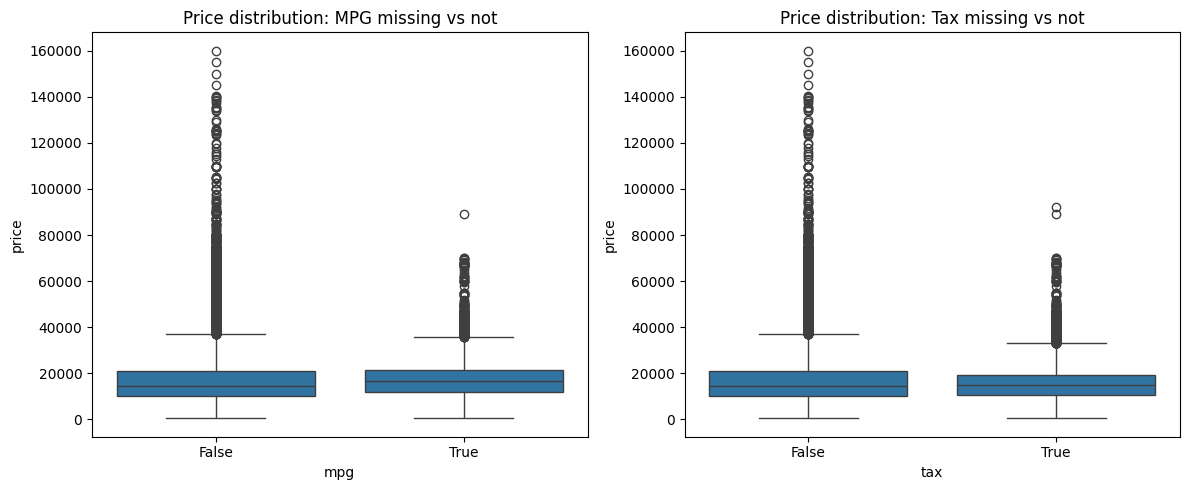

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=df['mpg'].isna(), y=df['price'], ax=axes[0])
axes[0].set_title('Price distribution: MPG missing vs not')

sns.boxplot(x=df['tax'].isna(), y=df['price'], ax=axes[1])
axes[1].set_title('Price distribution: Tax missing vs not')

plt.tight_layout()
plt.show()

theres no trend in the missingness of the mpd and tax . 

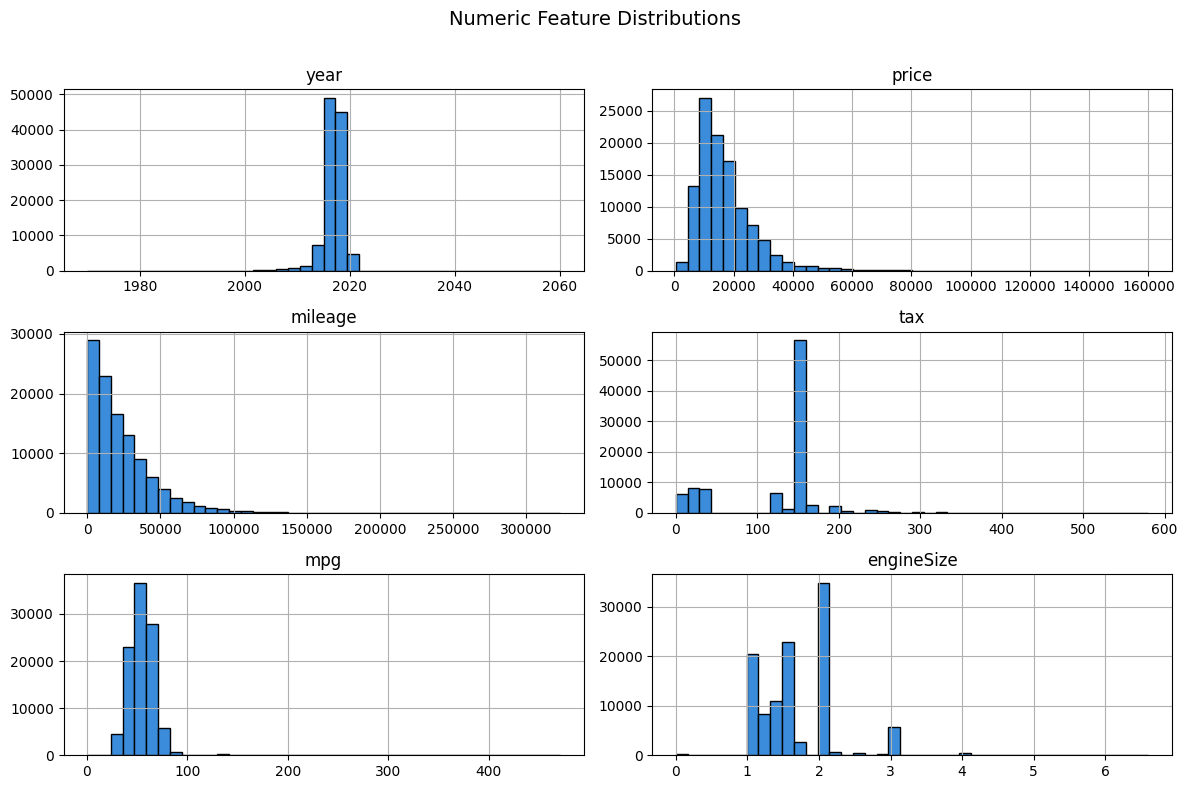

In [10]:
# Automatically pick numeric columns present in the dataframe
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()

# Plot histograms for numeric features
df[num_cols].hist(bins=40, figsize=(12,8), color="#3b8ddb", edgecolor="black")
plt.suptitle("Numeric Feature Distributions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


==== Correlation Matrix (numeric columns) ====


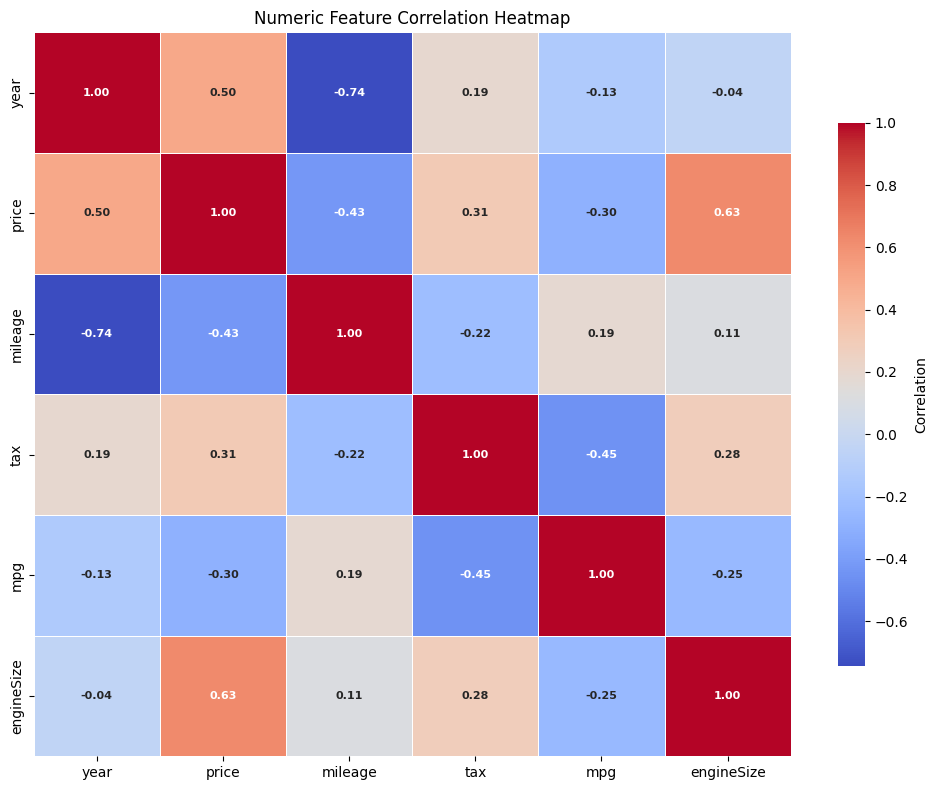

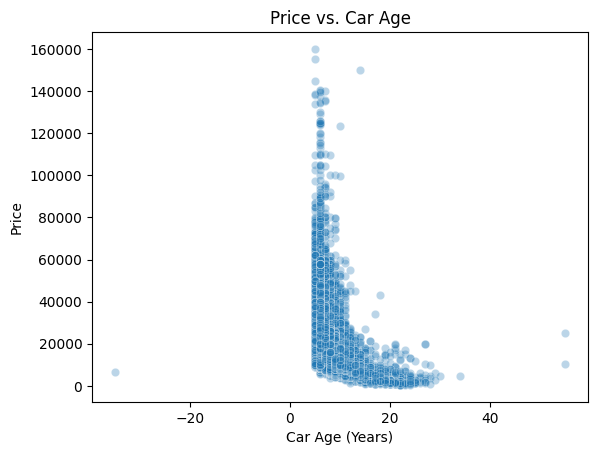

→ Expect: strong negative correlation (older cars cheaper). If it's noisy, consider log(price) or adding depreciation rate.


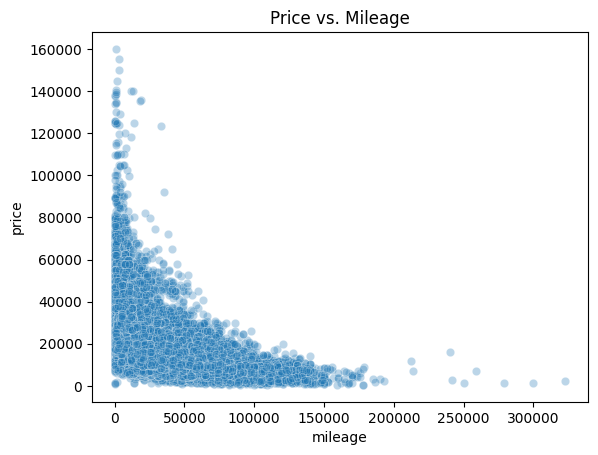

Correlation between price and mileage: -0.428
→ Usually around -0.5 to -0.7. If weaker, look at mileage_per_year instead of raw mileage.


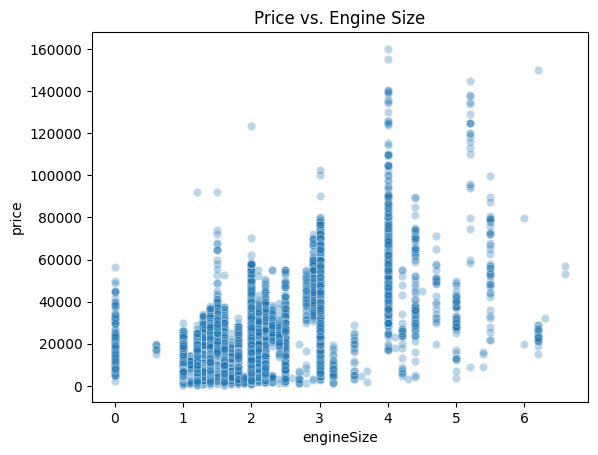

→ Larger engines often mean higher price for luxury/performance brands. Combine with mpg to form 'power_efficiency' later.


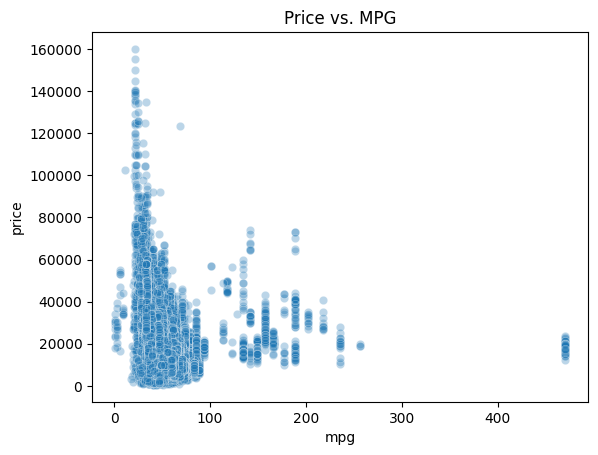

→ Expect negative trend: higher mpg (fuel efficiency) → lower price. Suggests we can build 'eco_score' combining mpg, tax, engineSize.


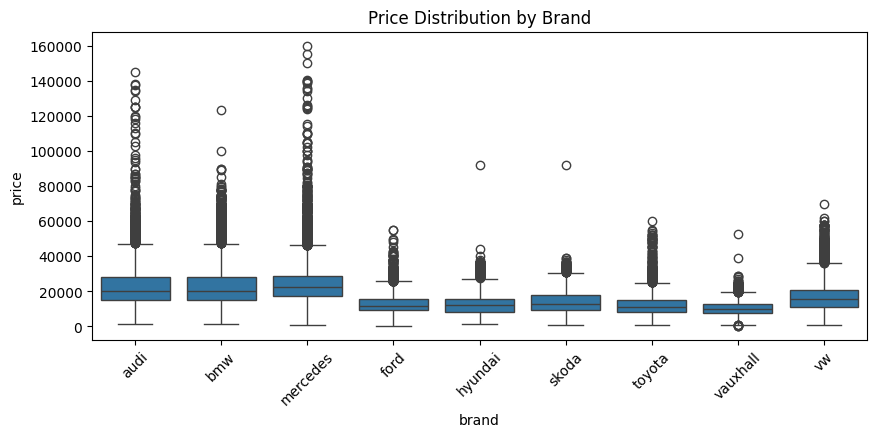

brand
mercedes    22505.0
bmw         20462.0
audi        20200.0
vw          15497.0
skoda       12998.0
hyundai     11990.0
ford        11750.0
toyota      10795.0
vauxhall     9999.0
Name: price, dtype: float64

→ Confirms which brands are 'luxury' vs 'economy' for brand_tier mapping.


In [11]:
# --- 6. Relationship insights for feature engineering ---

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("==== Correlation Matrix (numeric columns) ====")
num_cols = df.select_dtypes(include=["int64","float64"]).columns
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size":8, "weight":"bold"},
    linewidths=0.5,
    cbar_kws={"shrink":0.75, "label":"Correlation"}
)
plt.title("Numeric Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# --- 6A. Price vs. Age (temporary calculation only) ---
if "year" in df.columns:
    current_year = pd.Timestamp.now().year
    car_age = current_year - df["year"]     # temporary Series, not added to df
    sns.scatterplot(x=car_age, y=df["price"], alpha=0.3)
    plt.title("Price vs. Car Age")
    plt.xlabel("Car Age (Years)")
    plt.ylabel("Price")
    plt.show()
    print("→ Expect: strong negative correlation (older cars cheaper). "
          "If it's noisy, consider log(price) or adding depreciation rate.")

# --- 6B. Price vs. Mileage ---
if "mileage" in df.columns:
    sns.scatterplot(data=df, x="mileage", y="price", alpha=0.3)
    plt.title("Price vs. Mileage")
    plt.show()
    corr_val = df["price"].corr(df["mileage"])
    print(f"Correlation between price and mileage: {corr_val:.3f}")
    print("→ Usually around -0.5 to -0.7. "
          "If weaker, look at mileage_per_year instead of raw mileage.")

# --- 6C. Price vs. Engine Size ---
if "engineSize" in df.columns:
    sns.scatterplot(data=df, x="engineSize", y="price", alpha=0.3)
    plt.title("Price vs. Engine Size")
    plt.show()
    print("→ Larger engines often mean higher price for luxury/performance brands. "
          "Combine with mpg to form 'power_efficiency' later.")

# --- 6D. Price vs. MPG (Efficiency) ---
if "mpg" in df.columns:
    sns.scatterplot(data=df, x="mpg", y="price", alpha=0.3)
    plt.title("Price vs. MPG")
    plt.show()
    print("→ Expect negative trend: higher mpg (fuel efficiency) → lower price. "
          "Suggests we can build 'eco_score' combining mpg, tax, engineSize.")

# --- 6E. Brand-Level Trends ---
if "brand" in df.columns:
    plt.figure(figsize=(10,4))
    sns.boxplot(data=df, x="brand", y="price")
    plt.xticks(rotation=45)
    plt.title("Price Distribution by Brand")
    plt.show()

    brand_summary = df.groupby("brand")["price"].median().sort_values(ascending=False)
    display(brand_summary.head(10))
    print("→ Confirms which brands are 'luxury' vs 'economy' for brand_tier mapping.")


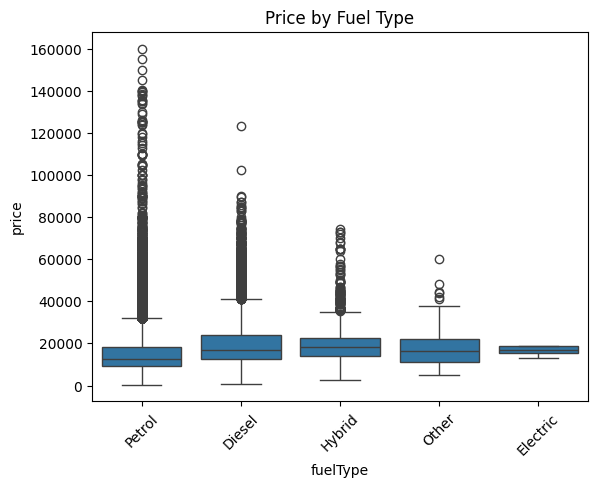

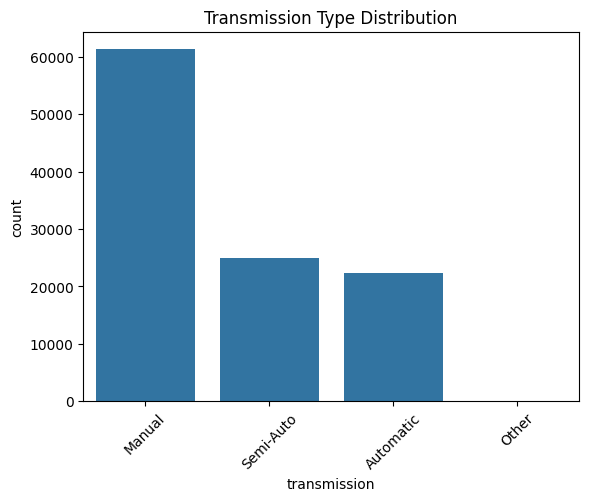

In [12]:
sns.boxplot(data=df, x="fuelType", y="price")
plt.title("Price by Fuel Type")
plt.xticks(rotation=45)
plt.show()

sns.countplot(data=df, x="transmission", order=df["transmission"].value_counts().index)
plt.title("Transmission Type Distribution")
plt.xticks(rotation=45)
plt.show()

In [13]:
# --- Model overview ---
print("Unique model names:", df['model'].nunique())
print("\nTop 20 models by frequency:")
display(df['model'].value_counts().head(20))

# If brand exists, check cross-distribution
if 'brand' in df.columns:
    brand_model_counts = (
        df.groupby('brand')['model']
        .nunique()
        .sort_values(ascending=False)
        .to_frame('unique_models_per_brand')
    )
    display(brand_model_counts)

# Top models per brand
if 'brand' in df.columns:
    top_models_by_brand = (
        df.groupby('brand')['model']
        .apply(lambda x: x.value_counts().head(3))
        .reset_index(name='count')
    )
    display(top_models_by_brand)


Unique model names: 195

Top 20 models by frequency:


model
Focus       10042
C Class      7646
Fiesta       6557
Golf         4863
Corsa        3441
Polo         3287
Astra        2805
A Class      2561
3 Series     2443
Kuga         2225
Mokka X      2127
Yaris        2122
1 Series     1969
Aygo         1961
E Class      1953
A3           1929
Tiguan       1765
Fabia        1571
Octavia      1477
Q3           1417
Name: count, dtype: int64

,unique_models_per_brand
brand,
mercedes,27
vw,27
audi,26
bmw,24
ford,23
vauxhall,22
toyota,18
hyundai,16
skoda,12


,brand,level_1,count
0,audi,A3,1929
1,audi,Q3,1417
2,audi,A4,1381
3,bmw,3 Series,2443
4,bmw,1 Series,1969
5,bmw,2 Series,1229
6,ford,Focus,10042
7,ford,Fiesta,6557
8,ford,Kuga,2225
9,hyundai,Tucson,1300


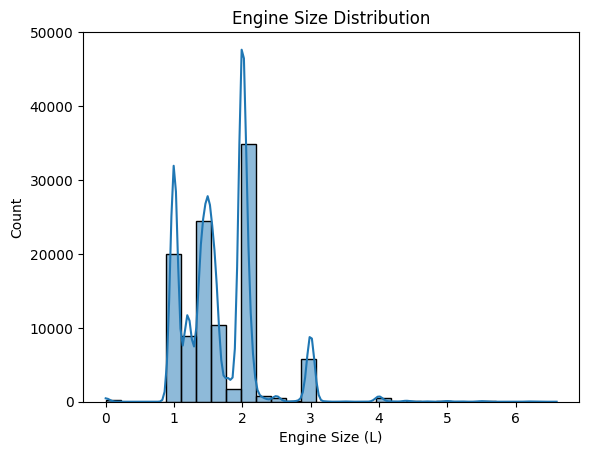

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['engineSize'], bins=30, kde=True)
plt.title('Engine Size Distribution')
plt.xlabel('Engine Size (L)')
plt.show()


In [15]:
import pandas as pd

numeric_cols = df.select_dtypes(include=['number']).columns

outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary.append({
        'column': col,
        'outliers': len(outliers),
        'percent_outliers': round(len(outliers) / len(df) * 100, 2),
        'lower_bound': round(lower, 2),
        'upper_bound': round(upper, 2)
    })

outlier_summary = pd.DataFrame(outlier_summary)
print(outlier_summary)


       column  outliers  percent_outliers  lower_bound  upper_bound
0        year      1946              1.79      2011.50      2023.50
1       price      3898              3.59     -5836.25     37005.75
2     mileage      4360              4.02    -29624.62     69352.38
3         tax     27445             25.29        95.00       175.00
4         mpg       939              0.87        23.55        86.35
5  engineSize       755              0.70        -0.00         3.20


In [16]:
df["year"].value_counts().sort_index()

year
1970        2
1991        1
1995        1
1996        2
1997        4
1998        9
1999        6
2000        9
2001       20
2002       36
2003       39
2004       55
2005       84
2006       92
2007      185
2008      233
2009      321
2010      369
2011      477
2012      702
2013     2818
2014     4377
2015     8359
2016    16948
2017    23686
2018    15092
2019    29955
2020     4657
2060        1
Name: count, dtype: int64

year cant be more than 2019 cuz the dataset is 2019, so we will simple remove those entries 
and we can check if maybe cars older than 1990 are vintage classic cars by seeing brands and stuff

In [17]:
df[df['year'] < 1990]['brand'].value_counts()


brand
mercedes    1
vauxhall    1
Name: count, dtype: int64

<Axes: xlabel='year', ylabel='price'>

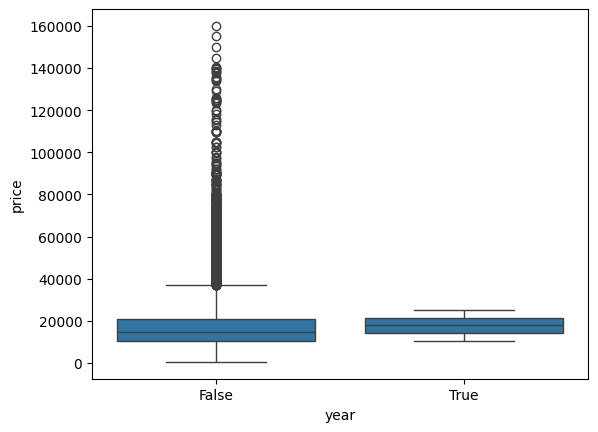

In [18]:
import seaborn as sns
sns.boxplot(x=(df['year'] < 1990), y='price', data=df)


In [19]:
old = df[df['year'] < 1990]
old.groupby('brand')[['price', 'mileage']].median().sort_values('price', ascending=False).head(10)


,price,mileage
brand,,
mercedes,24999.0,14000.0
vauxhall,10495.0,37357.0
